In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [5]:
import warnings
warnings.filterwarnings("ignore")
import logging 
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import tensorflow as tf
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
PROJECT_PATH = '../'
sys.path.insert(0, PROJECT_PATH)

In [31]:
Ws = {"Blue": [3800, 6500, 2300, "Blue"], "RedL": [6300, 9700, 3000, "RedL"], "RedM": [7100, 8850, 5000, "RedM"],
                   "NIR": [9400, 12600, 4300, "NIR"]}
Rs = {"M": ["M31 Giant", "M31G"], "W": ["MW Warm","MWW"], "C": ["MW Cool","MWC"],
      "B": ["BHB","BHB"], "R": ["RHB","RHB"], "G":["DwarfG Giant", "DGG"]}
Ps = {"M": [[-2.5, 0.0], [3500, 5000], [0.0, 2.0],[-0.75, 0.5], [-0.25, 0.5]], 
      "W": [[-2.0, 0.0], [5500, 7500], [3.5, 5.0],[-0.75, 0.5], [-0.25, 0.5]],
      "C": [[-2.0, 0.0], [4500, 6000], [4.0, 5.0],[-0.75, 0.5], [-0.25, 0.5]], 
      "B": [[-2.5,-1.5], [7000, 9500], [2.0, 3.0],[-0.75, 0.5], [-0.25, 0.5]],
      "R": [[-1.0, 0.0], [5000, 6500], [2.0, 3.0],[-0.75, 0.5], [-0.25, 0.5]], 
      "G": [[-2.5,-1.0], [3500, 5500], [0.0, 3.5],[-0.75, 0.5], [-0.25, 0.5]]}

### Load data

In [17]:
r="B"
W, R, P = Ws["RedM"], Rs[r], Ps[r]
WR = R[1] + " " +  W[3] + "Arm"
Prng = np.diff(P).T

In [9]:
SRBF_PATH = f"/scratch/ceph/swei20/data/dnn/{R[1]}/rbf_{W[3]}_R{W[2]}_100k.h5"
SRBFT_PATH = f"/scratch/ceph/swei20/data/dnn/{R[1]}/rbf_{W[3]}_R{W[2]}_1k.h5"

In [19]:
with h5py.File(SRBF_PATH, 'r') as f:
    normflux = f['normflux'][()]
    pnorm=f['pnorm'][()]
normflux.shape, pnorm.shape

((100000, 2204), (100000, 5))

In [20]:
with h5py.File(SRBFT_PATH, 'r') as f:
    normfluxT = f['normflux'][()]
    pnormT=f['pnorm'][()]
normfluxT.shape, pnormT.shape

((1000, 2204), (1000, 5))

In [ ]:
DNN_PC_PATH= f"/scratch/ceph/swei20/data/dnn/pc/bosz_{W[3]}_R{W[2]}.h5"
with h5py.File(DNN_PC_PATH, 'r') as f:
    pc  = f[f'pc{r}'][()]
pcflux = normflux.dot(pc.T)
pcfluxT = normfluxT.dot(pc.T)
print(pcflux.shape, pcfluxT.shape)

In [24]:
from dnn.model.dnn_model import DNN

In [25]:
dp=0.01
ep=1000
lr=0.01
y_train, y_test = pnorm, pnormT

Layers: [20, 128, 64, 32, 5]


2021-09-18 22:11:52.296114: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-18 22:11:52.340243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: NVIDIA Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-09-18 22:11:52.342364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-09-18 22:11:52.342496: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-18 22:11:54.377670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device inte

(100000, 20)


2021-09-18 22:11:55.041016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-18 22:11:55.041777: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2700000000 Hz
2021-09-18 22:11:55.900954: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-18 22:11:56.998804: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


| EP 1000 |loss: 0.0039 | mean_: 0.0039 | val_l: 0.0002 | val_m: 0.0002 | lr: 0.0001 | 


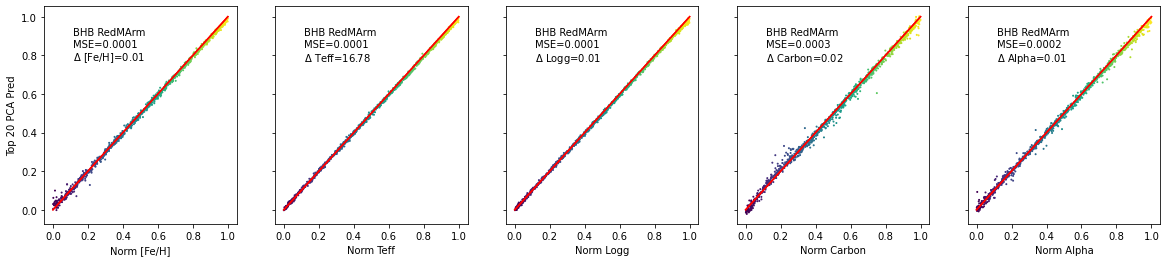

In [26]:
mtype="PCA"
top=20
x_train, x_test = get_x(r)
d = DNN(input_dim=top, hidden_dims=[], dp=dp, lr=lr, mtype=mtype)
d.build_model()
d.fit(x_train, y_train, top=top, ep=ep,verbose=0)
y_pred=d.eval(x_test, y_test, WR, Prng)

# M31G

In [44]:
def dataloader(r):
    W, R, P = Ws["RedM"], Rs[r], Ps[r]
    WR = R[1] + " " +  W[3] + "Arm"
    Prng = np.diff(P).T
    SRBF_PATH = f"/scratch/ceph/swei20/data/dnn/{R[1]}/rbf_{W[3]}_R{W[2]}_100k.h5"
    SRBFT_PATH = f"/scratch/ceph/swei20/data/dnn/{R[1]}/rbf_{W[3]}_R{W[2]}_1k.h5"
    with h5py.File(SRBF_PATH, 'r') as f:
        normflux = f['normflux'][()]
        pnorm=f['pnorm'][()]
    print(normflux.shape, pnorm.shape    )
    with h5py.File(SRBFT_PATH, 'r') as f:
        normfluxT = f['normflux'][()]
        pnormT=f['pnorm'][()]
    print(normfluxT.shape, pnormT.shape    )
    DNN_PC_PATH= f"/scratch/ceph/swei20/data/dnn/pc/bosz_{W[3]}_R{W[2]}.h5"
    with h5py.File(DNN_PC_PATH, 'r') as f:
        pc  = f[f'pc{r}'][()]
    pcflux = normflux.dot(pc.T)
    pcfluxT = normfluxT.dot(pc.T)
    print(pcflux.shape, pcfluxT.shape)
    return pcflux, pcfluxT, pnorm, pnormT

In [45]:
r="M"

In [46]:
dp=0.01
ep=1
lr=0.01
mtype="PCA"
x_train, x_test, y_train, y_test = dataloader(r)

OSError: Unable to open file (unable to open file: name = '/scratch/ceph/swei20/data/dnn/M31G/rbf_RedM_R5000_100k.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

(100000, 200) (1000, 200)
Layers: [20, 128, 64, 32, 5]
(100000, 20)
| EP 1 |loss: 0.0624 | mean_: 0.0624 | val_l: 0.0415 | val_m: 0.0415 | lr: 0.0100 | 


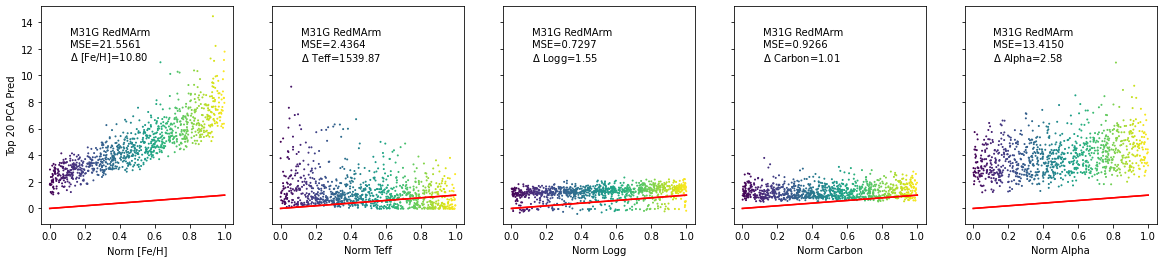

In [40]:
top=20
d = DNN(input_dim=top, hidden_dims=[], dp=dp, lr=lr, mtype=mtype)
d.build_model()
d.fit(x_train, y_train, top=top, ep=ep,verbose=0)
y_pred=d.eval(x_test, y_test, WR, Prng)

Layers: [20, 128, 64, 32, 5]
(100000, 20)
| EP 1000 |loss: 0.0038 | mean_: 0.0038 | val_l: 0.0002 | val_m: 0.0002 | lr: 0.0000 | 


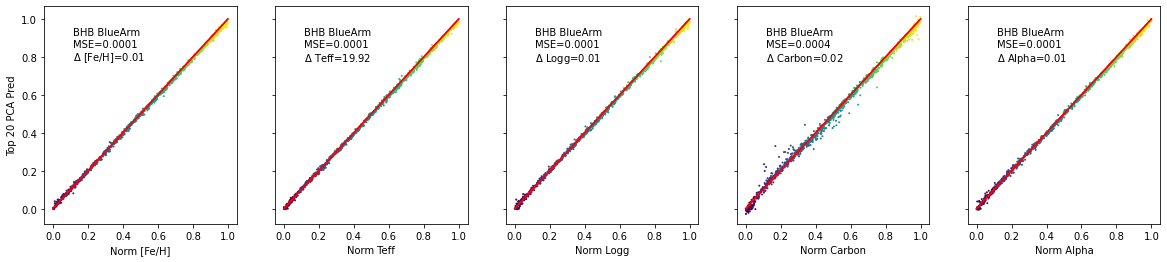

In [164]:
mtype="PCA"
top=20
x_train, x_test = pcflux, pcfluxT
d = DNN(input_dim=top, hidden_dims=[], dp=dp, lr=lr, mtype=mtype)
d.build_model()
d.fit(x_train, y_train, top=top, ep=ep,verbose=0)
y_pred=d.eval(x_test, y_test, WR, Prng)